# Braking System - Fault Prediction

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load the dataset
file_path = 'synthetic_brake_dataset_with_RUL.csv'
brake_data = pd.read_csv(file_path)

# Remove the RUL column as it's not required
brake_data = brake_data.drop(columns=['RUL'])

# Add more randomness to the synthetic fault condition
np.random.seed(42)  # For reproducibility
random_noise_stronger = np.random.rand(len(brake_data))

# Update fault_condition with stronger randomness
brake_data['fault_condition'] = np.where(
    (brake_data['Brake Pad Thickness'] < 3) |
    (brake_data['Brake Rotor Temperature'] > 320) |
    ((brake_data['Braking Pressure'] > 120) & (brake_data['ABS Activity Frequency'] > 0.5)) |
    (brake_data['Brake Fluid Quality'] < 0.4) |
    (brake_data['Rotor Temp Spike Detection'] == 1),
    1, 0
)

# Flip fault_condition with 10% probability to add more variability
brake_data['fault_condition'] = np.where(
    random_noise_stronger < 0.10, 1 - brake_data['fault_condition'], brake_data['fault_condition']
)

# Display the first few rows to verify the new column
brake_data


,Brake Pad Thickness,Brake Rotor Temperature,Braking Pressure,Brake Pedal Force,Vehicle Speed at Braking,Brake Fluid Quality,Time Since Last Replacement,Brake System Fault Codes,Rotor Temp Spike Detection,Brake Pressure Consistency,...,Vibration Sensor Data,Deceleration Rate,Wheel Speed Variation,ABS Sensor Readings,Brake Fluid Pressure,Brake Pedal Position Sensor,Brake Warning Indicator,Brake Caliper Temperature,Brake Pedal Response Time,fault_condition
0,9.917994,78.153866,24.405672,30,45,95.897276,-1476.436488,0,0,-0.137007,...,-0.052603,2.187586,-0.023065,0.900677,48.912240,1.057046,0,62.672878,0.091307,0
1,10.142455,71.292775,58.371249,70,46,98.790693,883.510566,0,0,-0.488269,...,4.585614,2.282282,-0.016336,0.897610,49.097991,0.999151,0,61.363947,0.076869,0
2,9.954267,74.192768,46.692462,70,101,94.134297,883.669143,0,0,-0.870479,...,0.193998,2.304609,0.033294,0.899365,50.146899,1.068478,0,51.477676,0.104313,0
3,9.998470,88.685339,65.572417,30,95,100.696916,937.160080,0,0,-1.536064,...,0.070148,1.978198,0.027419,1.024304,55.974721,0.937466,0,69.882636,0.051446,0
4,9.961633,60.239804,50.561971,50,55,105.854744,1234.086898,1,0,-0.098581,...,0.190331,2.258459,-0.008158,0.974896,55.352018,0.974834,0,52.769087,0.145269,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.133042,64.740894,62.247111,70,41,-0.054550,49221.249757,0,0,0.638505,...,-0.118611,2.339305,0.123300,1.117077,44.080639,1.046741,0,52.895238,0.085679,1
9996,1.062545,66.263758,60.524967,50,117,8.465606,50846.219125,0,0,1.032519,...,-0.034287,2.651618,0.117945,0.777724,47.554274,0.972090,0,66.728635,0.076379,1
9997,1.049012,67.606851,57.249031,90,33,-5.401552,52821.695207,0,0,0.837492,...,0.095868,3.130636,-0.000641,1.008272,51.669558,0.991683,0,55.822036,0.112372,1
9998,1.186952,71.205620,57.679110,50,100,-4.813009,52415.814823,0,0,-0.200350,...,-0.038402,1.647165,0.024027,0.916489,44.430003,0.953822,0,50.541373,0.077768,1


Missing Values:
 Series([], dtype: int64)


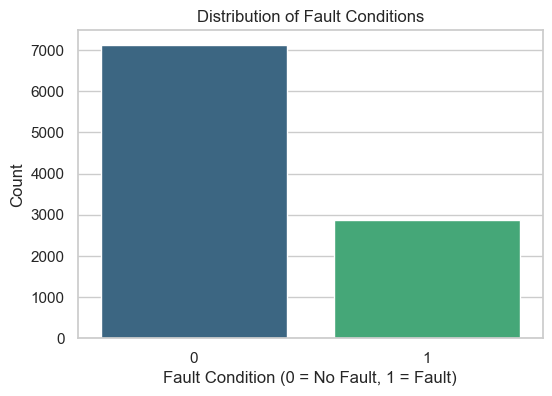

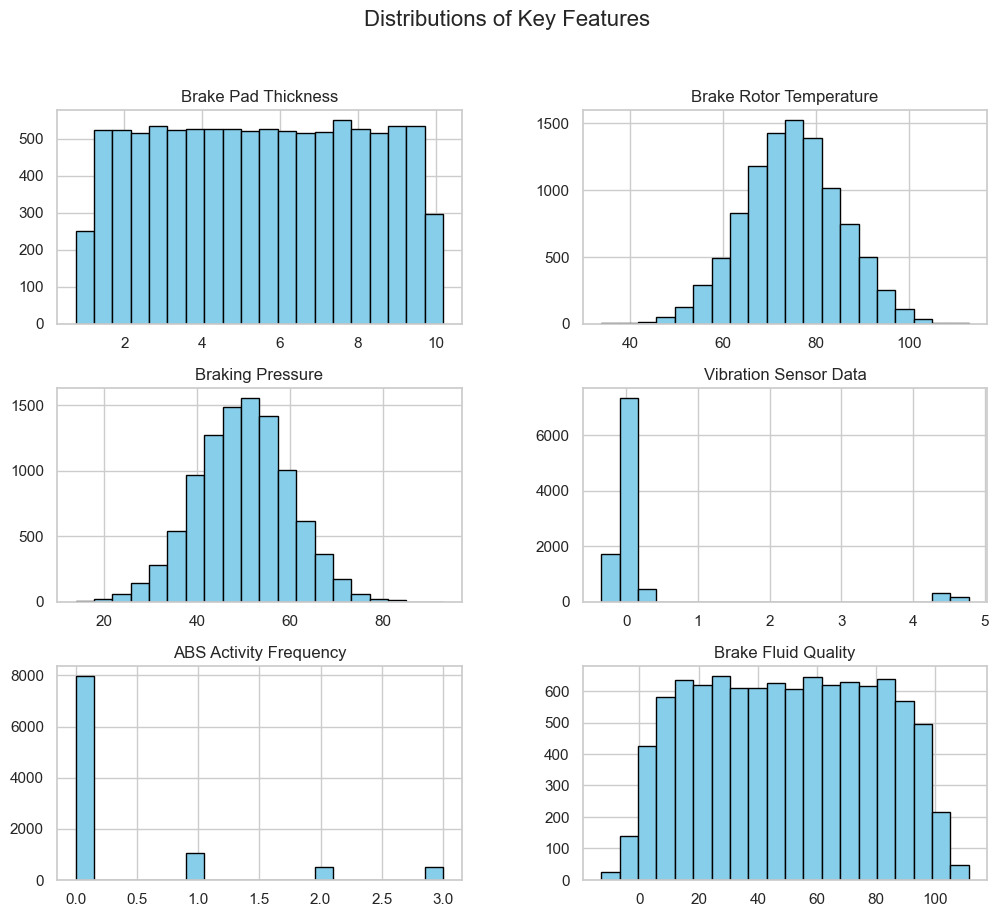

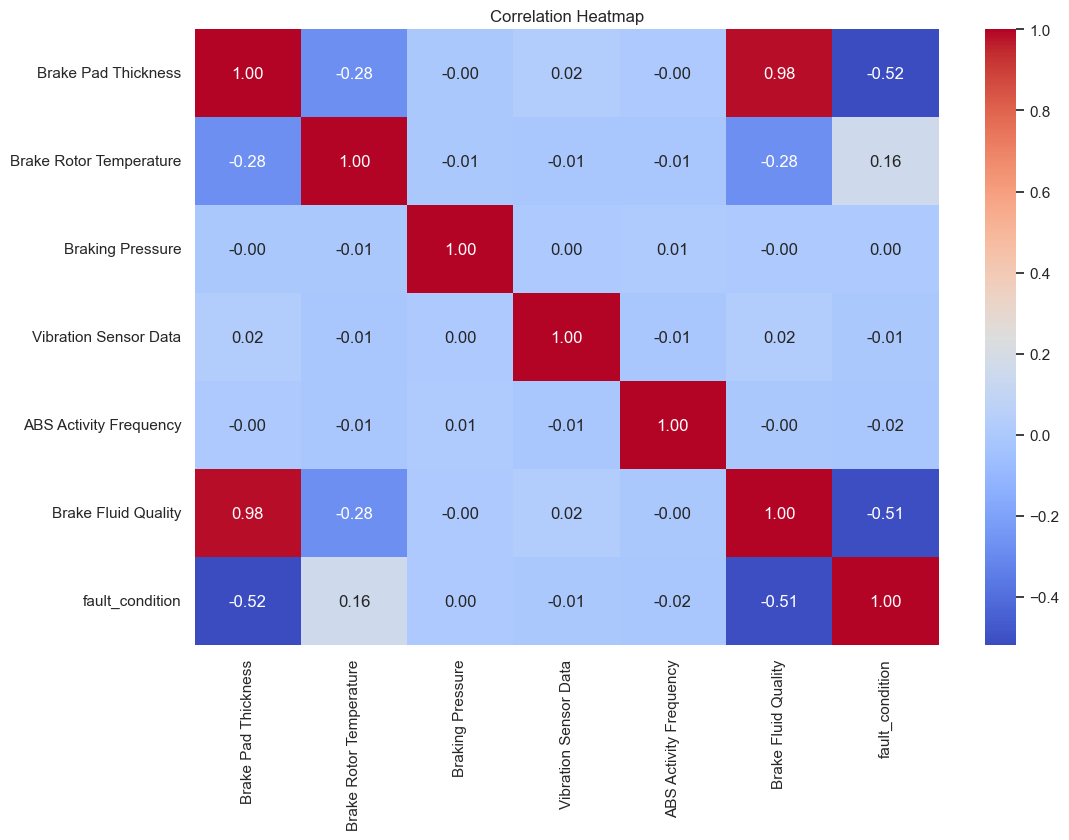

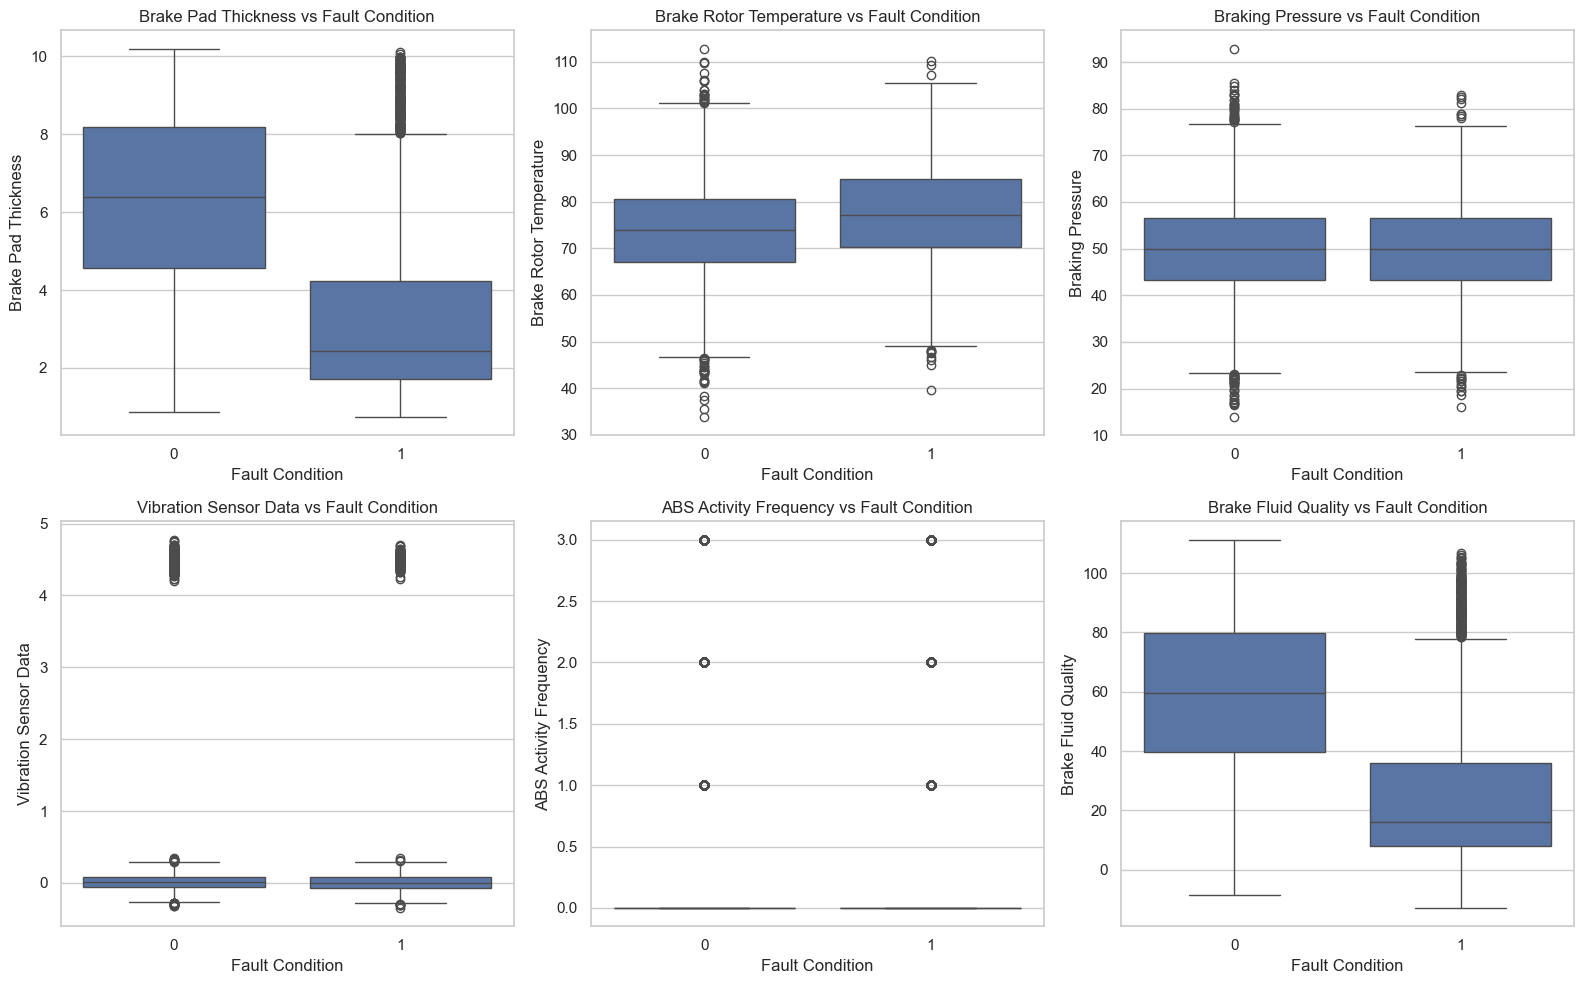

In [44]:


# Set the style for plots
sns.set(style="whitegrid")

# Step 2: Exploratory Data Analysis (EDA)

# Check for missing values
missing_values = brake_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Plot distribution of the synthetic 'fault_condition' column
plt.figure(figsize=(6, 4))
sns.countplot(data=brake_data, x='fault_condition', palette='viridis', hue='fault_condition', dodge=False, legend=False)
plt.title("Distribution of Fault Conditions")
plt.xlabel("Fault Condition (0 = No Fault, 1 = Fault)")
plt.ylabel("Count")
plt.show()

# Plot distributions for critical numerical features
critical_features = [
    'Brake Pad Thickness',
    'Brake Rotor Temperature',
    'Braking Pressure',
    'Vibration Sensor Data',
    'ABS Activity Frequency',
    'Brake Fluid Quality'
]

brake_data[critical_features].hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Key Features", fontsize=16)
plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = brake_data[critical_features + ['fault_condition']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Box plots for features vs. fault condition
plt.figure(figsize=(16, 10))
for i, feature in enumerate(critical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=brake_data, x='fault_condition', y=feature)
    plt.title(f"{feature} vs Fault Condition")
    plt.xlabel("Fault Condition")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


In [46]:


# Step 3: Data Cleaning - Handling Missing Values and Outliers

# Handling Missing Values
# Use median imputation for numerical columns
numerical_features = brake_data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy="median")
brake_data[numerical_features] = imputer.fit_transform(brake_data[numerical_features])

# Verify no missing values remain
print("Missing Values After Imputation:\n", brake_data.isnull().sum().sum())

# Handling Outliers
# Define a function to remove outliers based on the IQR method
def remove_outliers(df, columns, multiplier=1.5):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        # Filter values within the range
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply outlier removal on critical features
critical_features = [
    'Brake Pad Thickness',
    'Brake Rotor Temperature',
    'Braking Pressure',
    'Vibration Sensor Data',
    'ABS Activity Frequency',
    'Brake Fluid Quality'
]
brake_data_cleaned = remove_outliers(brake_data, critical_features)

# Print the difference in data size after removing outliers
print(f"Original Dataset Size: {len(brake_data)}")
print(f"Dataset Size After Outlier Removal: {len(brake_data_cleaned)}")


Missing Values After Imputation:
 0
Original Dataset Size: 10000
Dataset Size After Outlier Removal: 7418


In [48]:


# Step 4: Feature Scaling and Train-Test Split

# Define features (X) and target (y)
features = [
    'Brake Pad Thickness',
    'Brake Rotor Temperature',
    'Braking Pressure',
    'Vibration Sensor Data',
    'ABS Activity Frequency',
    'Brake Fluid Quality'
]
X = brake_data_cleaned[features]
y = brake_data_cleaned['fault_condition']

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# Display the shapes of the resulting splits
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)


Training Features Shape: (5192, 6)
Testing Features Shape: (2226, 6)
Training Labels Shape: (5192,)
Testing Labels Shape: (2226,)


In [50]:
# Updated Hyperparameter Grid for stricter regularization
param_grid_tweaked = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [30, 40],
    'min_samples_leaf': [20, 30],
    'max_features': ['sqrt']
}

# Perform GridSearchCV
grid_search_tweaked = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_tweaked,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search_tweaked.fit(X_train, y_train)

# Retrieve the best model and parameters
best_model_tweaked = grid_search_tweaked.best_estimator_
best_params_tweaked = grid_search_tweaked.best_params_

# Cross-validation score
cv_auc_score_tweaked = cross_val_score(
    best_model_tweaked, X_train, y_train, cv=5, scoring='roc_auc'
).mean()

# Model Evaluation on Test Data
y_pred_tweaked = best_model_tweaked.predict(X_test)
accuracy_tweaked = accuracy_score(y_test, y_pred_tweaked)
precision_tweaked = precision_score(y_test, y_pred_tweaked)
recall_tweaked = recall_score(y_test, y_pred_tweaked)
f1_tweaked = f1_score(y_test, y_pred_tweaked)
roc_auc_tweaked = roc_auc_score(y_test, best_model_tweaked.predict_proba(X_test)[:, 1])

# Print updated metrics
print("Updated Best Parameters:", best_params_tweaked)
print("Updated Cross-Validation AUC-ROC Score:", cv_auc_score_tweaked)
print("Updated Accuracy:", accuracy_tweaked)
print("Updated Precision:", precision_tweaked)
print("Updated Recall:", recall_tweaked)
print("Updated F1 Score:", f1_tweaked)
print("Updated AUC-ROC:", roc_auc_tweaked)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Updated Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 50}
Updated Cross-Validation AUC-ROC Score: 0.8333850925313522
Updated Accuracy: 0.889937106918239
Updated Precision: 0.907070707070707
Updated Recall: 0.6929012345679012
Updated F1 Score: 0.7856517935258093
Updated AUC-ROC: 0.8442560906914519


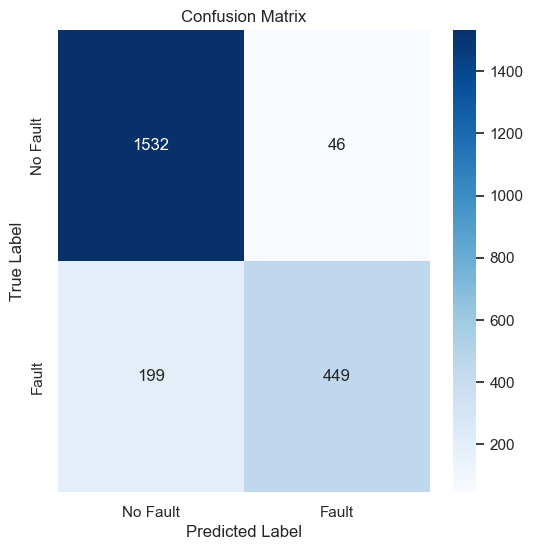

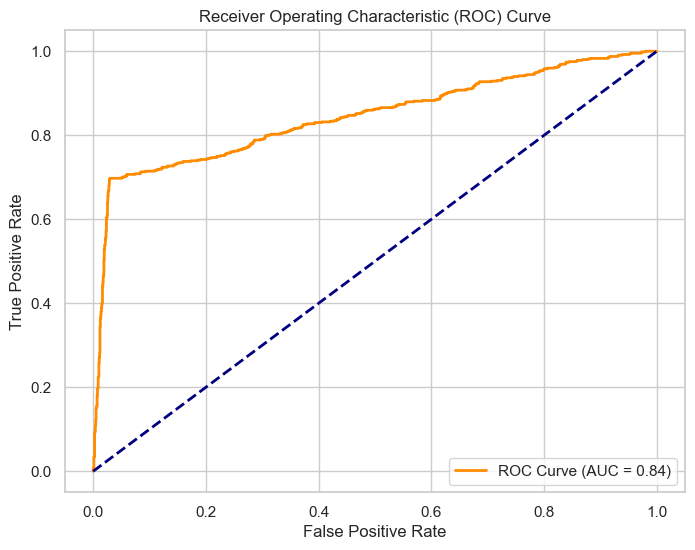

C:\Users\mural\AppData\Local\Temp\ipykernel_9508\1858425669.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='viridis')


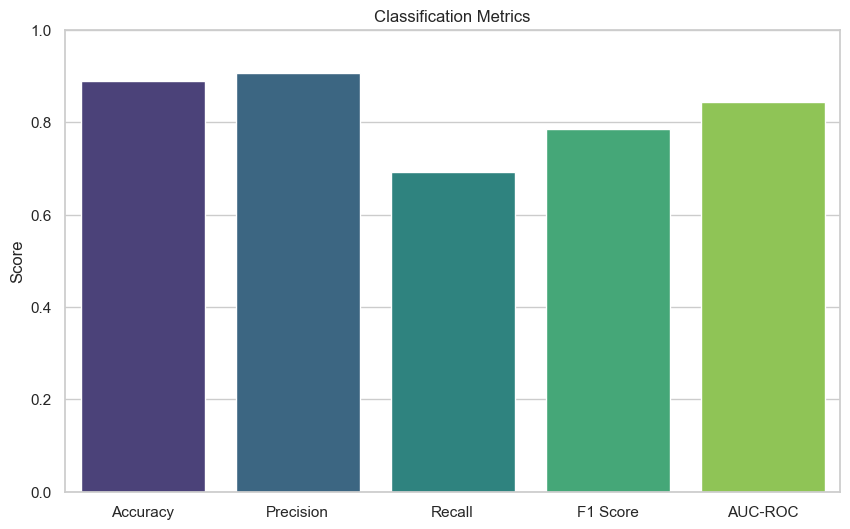

In [62]:


# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['No Fault', 'Fault']
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# ROC Curve Visualization
def plot_roc_curve(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Classification Metrics Visualization
def plot_metrics(accuracy, precision, recall, f1, auc_roc):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
    scores = [accuracy, precision, recall, f1, auc_roc]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=scores, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.show()

# Visualize Confusion Matrix
plot_confusion_matrix(y_test, y_pred_tweaked)

# Visualize ROC Curve
y_proba_tweaked = best_model_tweaked.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_proba_tweaked)

# Visualize Classification Metrics
plot_metrics(accuracy_tweaked, precision_tweaked, recall_tweaked, f1_tweaked, roc_auc_tweaked)


In [66]:
import pickle

# Saving the model
model_filename = 'FP_braking_system.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model_tweaked, file)
print(f"Model saved to {model_filename}")

# Loading the model (verification step or for deployment)
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")


Model saved to FP_braking_system.pkl
Model loaded successfully.
